# Local Model

Named **local** as this will all be written in Python 3 with datasets that will be of suitable scale for use on a local machine (of, say, a RAM of 8GB). We do not want to get *too* crazy here, after all. Baby steps.

In [37]:
import os
import numpy as np
import pandas as pd

In [38]:
STOCKS_PATH = "data/"

In [39]:
def load_stocks_data(stocks_path=STOCKS_PATH):
    csv_path = os.path.join(stocks_path, "2018_Financial_Data.csv")
    return pd.read_csv(csv_path)

stocks = load_stocks_data()

In [40]:
stocks.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1


## 1. Create a test set

### Stratified sampling

used stratified sampling based on the sector that the company comes from.

In [41]:
stocks["Sector"].value_counts()

Financial Services        824
Healthcare                691
Technology                636
Industrials               574
Consumer Cyclical         506
Basic Materials           276
Real Estate               255
Energy                    248
Consumer Defensive        191
Utilities                 102
Communication Services     89
Name: Sector, dtype: int64

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(stocks, stocks["Sector"]):
    strat_train_set = stocks.loc[train_index]
    strat_test_set = stocks.loc[test_index]

In [43]:
strat_test_set["Sector"].value_counts() / len(strat_test_set)

Financial Services        0.187713
Healthcare                0.156997
Technology                0.144482
Industrials               0.130830
Consumer Cyclical         0.114903
Basic Materials           0.062571
Real Estate               0.058020
Energy                    0.056883
Consumer Defensive        0.043231
Utilities                 0.023891
Communication Services    0.020478
Name: Sector, dtype: float64

In [44]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["Unnamed: 0", "Class"], axis=1, inplace=True)

Drop both *Unnamed: 0* and *Class* because there is no need for the ticker symbol and the latter is derived on if *2019 PRICE VAR [%]* is positive or negative.

## 2. Visualise the dataset

Look for correlations in the dataset.

In [47]:
stocks = strat_train_set.copy()

In [48]:
corr_matrix = stocks.corr()

In [63]:
corr_matrix["2019 PRICE VAR [%]"].sort_values(ascending=False)

2019 PRICE VAR [%]                     1.000000
operatingCycle                         0.185847
cashConversionCycle                    0.111524
5Y Net Income Growth (per Share)       0.078612
10Y Operating CF Growth (per Share)    0.077201
                                         ...   
Graham Number                         -0.040675
Tangible Book Value per Share         -0.040897
dividendpaidAndCapexCoverageRatios    -0.096792
capitalExpenditureCoverageRatios      -0.096858
operatingProfitMargin                       NaN
Name: 2019 PRICE VAR [%], Length: 222, dtype: float64

There are very weak correlations with the the price variance. This was to be expected - if there were a significant correlation with at least one variable, then the stock market may not be as chaotic as it is.

Pick out a few of the top correlations and make a scatter plot to see if a visual reveals anything more.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e7acc9810>,
      dtype=object)

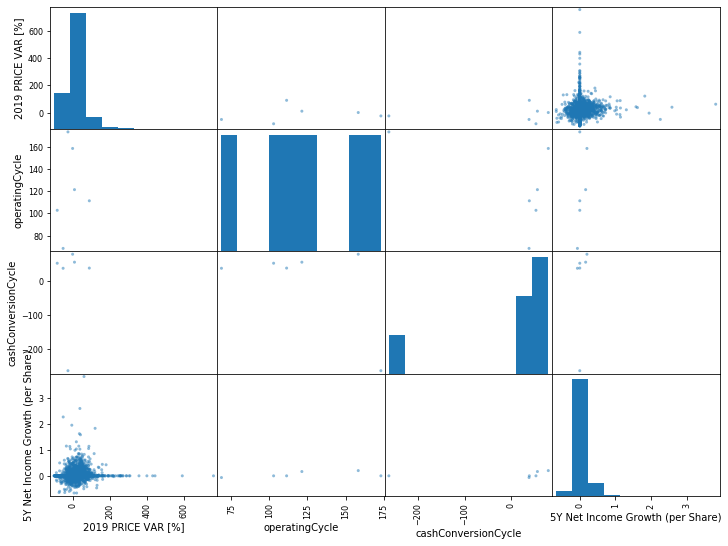

In [65]:
from pandas.plotting import scatter_matrix

attributes = ["2019 PRICE VAR [%]", "operatingCycle", "cashConversionCycle"
             , "5Y Net Income Growth (per Share)"]
scatter_matrix(stocks[attributes], figsize=(12,9))

The *operatingCycle* and *cashConversionCycle* plots were disappointing - investigate this more to see if there is a lot of missing data.

In [58]:
for col in ["operatingCycle", "cashConversionCycle"]:
    print('Pct null values: {}'.format(stocks[stocks[col].isna()].shape[0] / stocks.shape[0]))

Pct null values: 0.9982920580700256
Pct null values: 0.9982920580700256


There we have it - over $99.8$% of vaules were null. This will be discarded from the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e7cb49510>,
      dtype=object)

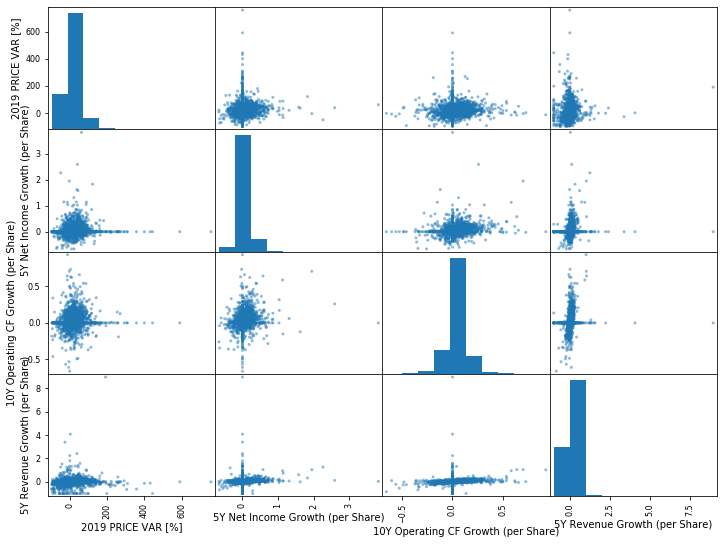

In [62]:
attributes = ["2019 PRICE VAR [%]", "5Y Net Income Growth (per Share)"
             , "10Y Operating CF Growth (per Share)", "5Y Revenue Growth (per Share)"]
scatter_matrix(stocks[attributes], figsize=(12,9))

Each of these distributions look like a lot of companies will have data missing and filled only with a zero. This can be spotted by the highly dense straight lines on the axes in each of the scatter plots.

## 3. Feature Engineering

*no ideas on this yet*

## 4. Prepare the data for machine learning algorithms

In [66]:
stocks = strat_train_set.drop("2019 PRICE VAR [%]", axis=1)
stocks_labels = strat_train_set["2019 PRICE VAR [%]"].copy()

In [67]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [68]:
stocks_num = stocks.drop(["Sector"], axis=1)
imputer.fit(stocks_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [69]:
X = imputer.transform(stocks_num)

In [70]:
stocks_tr = pd.DataFrame(X, columns = stocks_num.columns
                        , index = stocks_num.index)

In [71]:
stocks_tr.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth
4085,5.923000e+06,0.2441,4.081000e+06,1842000.0,1746000.0,6825000.0,8571000.0,-6729000.0,0.0,-6700000.0,...,0.0000,0.0000,0.0000,0.6419,-0.0275,-0.3924,-0.5285,0.0000,0.8093,0.0955
1919,1.502932e+09,0.3987,1.141886e+09,361046000.0,0.0,179316000.0,260539000.0,100507000.0,265000.0,117073000.0,...,-1.0000,-1.0000,-1.0000,-0.2676,0.0495,0.1136,0.1315,-0.4433,0.0000,0.0187
2778,7.192670e+08,0.0382,4.488320e+08,270435000.0,4183000.0,67552000.0,85325000.0,185110000.0,70924000.0,132699000.0,...,0.1024,0.4596,0.2679,0.1873,1.3029,0.1896,0.0781,0.3878,0.3250,0.1551
1477,1.771456e+09,0.3210,1.361431e+09,410025000.0,0.0,93558000.0,341085000.0,68940000.0,147003000.0,-179245000.0,...,0.0000,0.0000,0.0000,0.0185,-0.0356,0.0415,40.7030,0.6131,0.0000,-0.1090
3983,3.227500e+07,0.0474,0.000000e+00,32275000.0,0.0,20348000.0,21615000.0,10660000.0,0.0,10647000.0,...,-0.0029,-0.0292,-0.0635,0.0000,0.0000,0.0464,0.0545,-1.0000,0.0000,0.0561


### 5.1 Handling text attributes

In [76]:
stocks_cat = stocks[["Sector"]]

In [77]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
stocks_cat_1hot = cat_encoder.fit_transform(stocks_cat)
stocks_cat_1hot

<3513x11 sparse matrix of type '<class 'numpy.float64'>'
	with 3513 stored elements in Compressed Sparse Row format>

### 5.2 Custom Transformers

*Reserving the space in anticipation of feature engineering*

### 5.3 Pipelines

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [79]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median"))
    , ('std_scaler', StandardScaler())
])

stocks_num_tr = num_pipeline.fit_transform(stocks_num)

In [80]:
from sklearn.compose import ColumnTransformer

num_attribs = list(stocks_num)
cat_attribs = ["Sector"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs)
    , ("cat", OneHotEncoder(), cat_attribs)
])

stocks_prepared = full_pipeline.fit_transform(stocks)

## 6. Select and train a model

### 6.1 Start off with a simple Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(stocks_prepared, stocks_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
some_data = stocks.iloc[:5]
some_labels = stocks_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [12.84814453 15.59423828 17.73583984 35.83349609 21.63574219]
Labels: [93.75000582076622, 1.8006005938353835, 45.081757985134715, 55.30753820894285, 78.99077197058554]


In [85]:
from sklearn.metrics import mean_squared_error
stocks_predictions = lin_reg.predict(stocks_prepared)
lin_mse = mean_squared_error(stocks_labels, stocks_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

52.09332970893826

---

In [92]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(stocks_prepared, stocks_labels)

stocks_predictions = forest_reg.predict(stocks_prepared)
forest_mse = mean_squared_error(stocks_labels, stocks_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

20.44901997339327

---

In [ ]:
from sklearn.model_selection import cross_val_score

for model_name, model in [('Linear Regression', lin_reg)('Random Forest Regressor', forest_reg)]:
    scores = cross_val_score(model, stocks_prepared, stocks_labels
                             , scoring="neg_mean_squared_error", cv=10)
    display_scores(scores)
    print("\n\n")

Scores: [-4.98897875e+03 -1.02279421e+05 -4.32959304e+11 -1.13371002e+08
 -2.62529260e+03 -6.63091359e+06 -9.60056325e+06 -3.50803887e+11
 -1.93515108e+05 -1.52278675e+07]
Mean: -78390832478.77156
Standard Deviation: 157818222364.48615





In [89]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())